<a href="https://colab.research.google.com/github/jd2504/bme_dsp_2025/blob/main/06.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import sys

bme_repo = "https://github.com/jd2504/bme_dsp_2025.git"
repo_name = bme_repo.split('/')[-1].replace('.git', '')
!git clone {bme_repo}
sys.path.append(os.path.join(os.getcwd(), repo_name))
import bmedsp_helpers as bme

Cloning into 'bme_dsp_2025'...
remote: Enumerating objects: 52, done.
remote: Counting objects: 100% (52/52), done.
remote: Compressing objects: 100% (48/48), done.
remote: Total 52 (delta 20), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (52/52), 2.13 MiB | 5.93 MiB/s, done.
Resolving deltas: 100% (20/20), done.


# Alpha power

Create a bandpass filter for alpha activity (~10 Hz). Filter the data
and estimate at what times the person has their eyes open
and closed (alpha activity is stronger when the eyes are closed).
The output of the homework should be a figure with the following
panels.

1.) PSD before and after filtering in one figure.

2.) Magnitude response of the filter

3.) Phase response of the filter

4.) Show the instantaneous amplitude and instantaneous frequency.

5.) Signal before and after filtering with vertical lines indicating
the moments where the eyes are open or closed.
The data is online stored as alpha.mat

In [ ]:
import numpy as np
from scipy import signal, stats
from matplotlib import pyplot as plt

In [ ]:
file_input = bme.grab_mat('alpha.mat')

https://parralab.org/teaching/biomed-dsp/alpha.mat
dict_keys(['__header__', '__version__', '__globals__', 'fs', 'x'])
b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Wed Oct 15 14:09:28 2014'


In [ ]:
fs = file_input['fs'][0][0]
x = file_input['x'].T[0]

In [ ]:
x.shape

(81919,)

In [ ]:
# high pass
#[b,a]=butter[2,0.5/(fs/2), 'high');]

# freqz(b, a, [], fs]) # phase response in matlab
# scipy.signal.freqz

In [ ]:
def gaborfir(fc, fs, Q):
    """
    fc: center freq in Hz
    fs:
    Q: quality factor, bw relative to center freq

    implements lucas function: function b=gaborfir(fc,fs,Q)
        df = fc/Q; % bandwidth in Hz,
        dt = 1/df;
        t = (-3*dt*fs:3*dt*fs)'/fs;
        b = 1/sqrt(pi/2)/fs/dt*exp(-t.^2/2/dt^2).*exp(sqrt(-1)*2*pi*fc*t);
    """
    df = fc/Q  # bandwidth in Hz
    dt = 1/df  # t const related to gauss env spread

    # t = (-3*dt*fs:3*dt*fs)'/fs;
    t_start = -3 * dt * fs
    t_end = 3 * dt * fs

    t_idx = np.arange(np.ceil(t_start), np.floor(t_end) + 1)
    t = t_idx / fs # s

    # b = (1 / sqrt(pi/2) / fs / dt) * exp(-t^2 / (2*dt^2)) * exp(i * 2*pi*fc*t)
    term1 = 1 / (np.sqrt(np.pi / 2) * fs * dt) # normalization factor?
    term2 = np.exp(-t**2 / (2 * dt**2)) # gaussian envelope
    term3 = np.exp(1j * 2 * np.pi * fc * t) # carrier wave

    b = term1 * term2 * term3
    return b

- inst power: $ P(t) = \| y_a (t) \|^2 $

- inst phase: $ \Phi(t) = arg(y_a(t)) $

- inst angular freq: $ \omega (t) = \frac{\partial \Phi (t)}{\partial t} $

- inst temporal freq: $ f(t) = \frac{1}{2 \pi} \frac{\partial \Phi (t)}{\partial t} $

In [ ]:
fc_a = 10.0
Q_a = 3

# time arrays
N = len(x)
T = N/fs
t = np.linspace(0, T, N)

b_gabor = gaborfir(fc_a, fs, Q_a)

y_a = signal.convolve(x, b_gabor, mode='same')
y_a_env = np.abs(y_a)

phi = np.unwrap(np.angle(y_a)) # IP
# discrete-time IF formula: f[n] = (fs / 2*pi) * phase_diff
dphi = np.gradient(phi)
ft = (fs / (2 * np.pi)) * dphi

# t_freq = t[:-1] #np.diff trunc

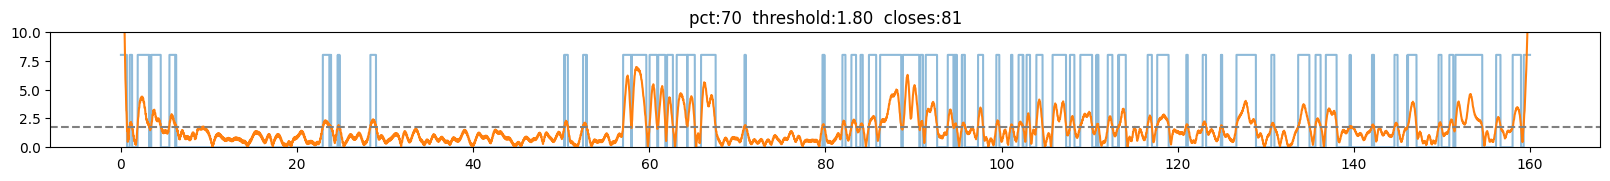

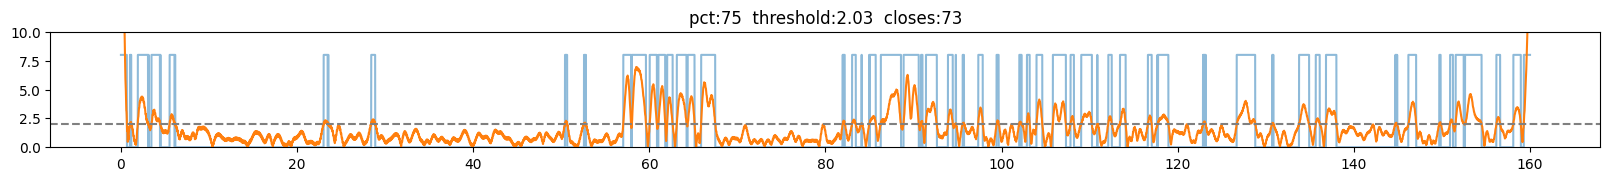

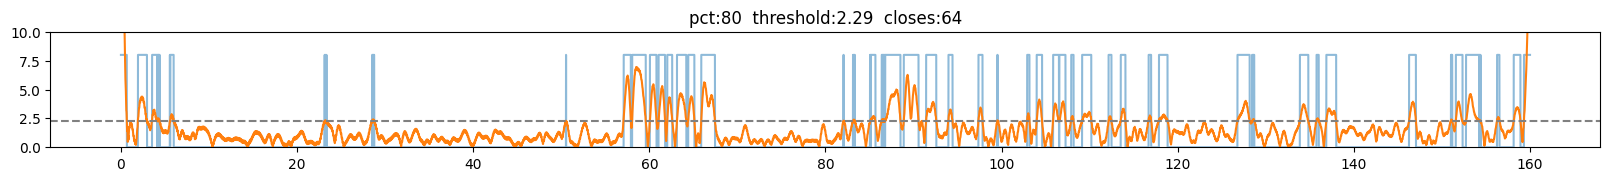

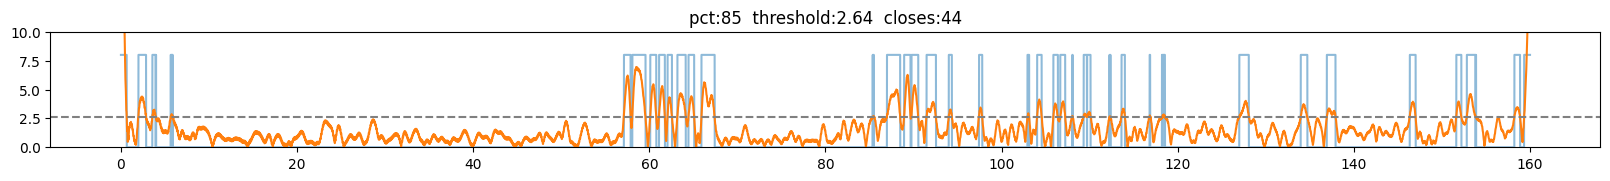

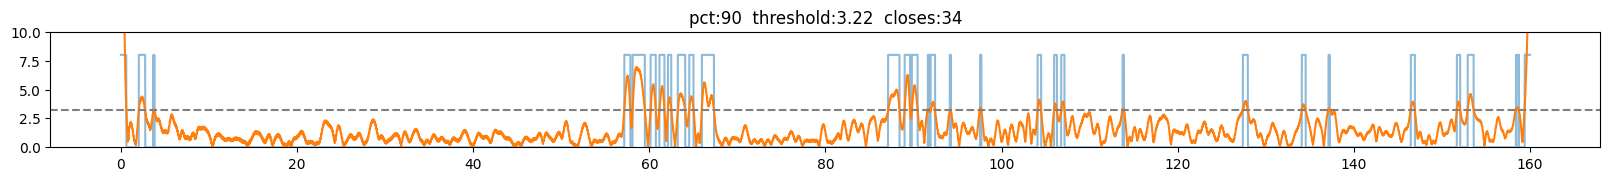

In [ ]:
# eye-balling eyes closed alpha power threshold setting...

for p in np.arange(70, 91, 5):
    a_perc = p
    a_threshold = np.percentile(y_a_env, a_perc)

    eyes_closed = np.zeros(len(y_a_env))

    for i in range(len(y_a_env)):
        if y_a_env[i] > a_threshold:
            eyes_closed[i] = 1

    closes = (np.diff(eyes_closed) > 0).sum()

    plt.figure(figsize=(20,1.5))
    plt.title(f"pct:{p}  threshold:{a_threshold:.2f}  closes:{closes}")
    plt.plot(t, eyes_closed*8, alpha=0.5)
    plt.plot(t, y_a_env)
    plt.axhline(y=a_threshold, ls='--', c='grey')
    plt.ylim(0,10)
    plt.show()

In [ ]:
# percentile threshold
a_perc = 85.0
a_threshold = np.percentile(y_a_env, a_perc)

eyes_closed = np.zeros(len(y_a_env))

for i in range(len(y_a_env)):
    if y_a_env[i] > a_threshold:
        eyes_closed[i] = 1

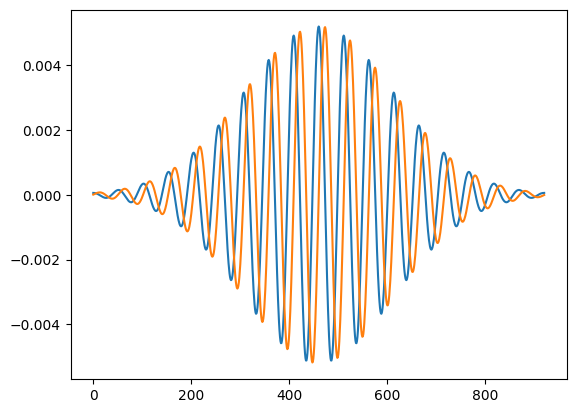

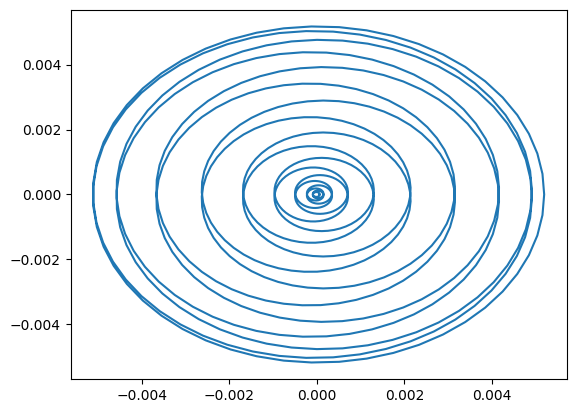

In [ ]:
plt.plot(b_gabor.real)
plt.plot(b_gabor.imag)
plt.show()

plt.plot(b_gabor.real, b_gabor.imag)
plt.show()

# 1. & 5. PSD before and after applying Gabor filter

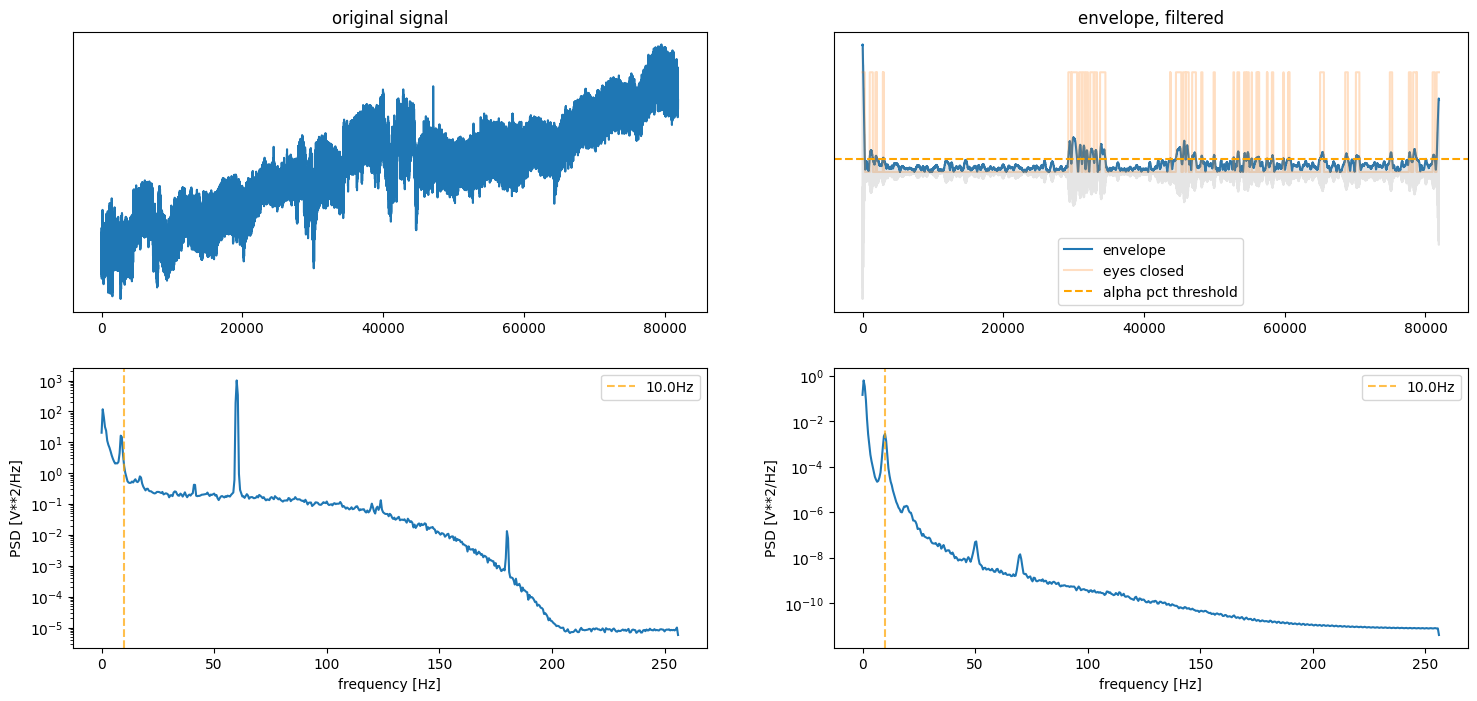

In [ ]:
plt.figure(figsize=(18,8))

plt.subplot(2,2,1)
plt.title('original signal')
plt.plot(x)
plt.yticks([])

plt.subplot(2,2,2)
plt.title('envelope, filtered')
plt.plot(y_a_env, label='envelope')
plt.plot(eyes_closed*20, alpha=0.25, label='eyes closed')
plt.plot(y_a, alpha=0.2, c='grey')
plt.axhline(y=a_threshold, c='orange', ls='--', label='alpha pct threshold')
plt.yticks([])
plt.legend()

plt.subplot(2,2,3)
f, Pxx_den = signal.welch(x, fs, nperseg=1024)
plt.semilogy(f, Pxx_den)
plt.axvline(x=fc_a, ls='--', color='orange', label=f'{fc_a}Hz', alpha=0.7)
# plt.ylim([0.5e-3, 1])
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.legend()
# plt.show()

plt.subplot(2,2,4)
f, Pxx_den = signal.welch(y_a_env, fs, nperseg=1024)
plt.semilogy(f, Pxx_den)
plt.axvline(x=fc_a, ls='--', color='orange', label=f'{fc_a}Hz', alpha=0.7)
# plt.ylim([0.5e-3, 1])
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.legend()
plt.show()

# 2. Magnitude and phase response of filter

In [ ]:
w, h = signal.freqz(b_gabor, a=1)
f = w * fs / (2 * np.pi) # ang freq w (rads/sample) to freq

H = 20 * np.log10(np.abs(h)) # mag resp (gain -> dB)
phase = np.unwrap(np.angle(h)) * 180 / np.pi # # phase resp (degr)

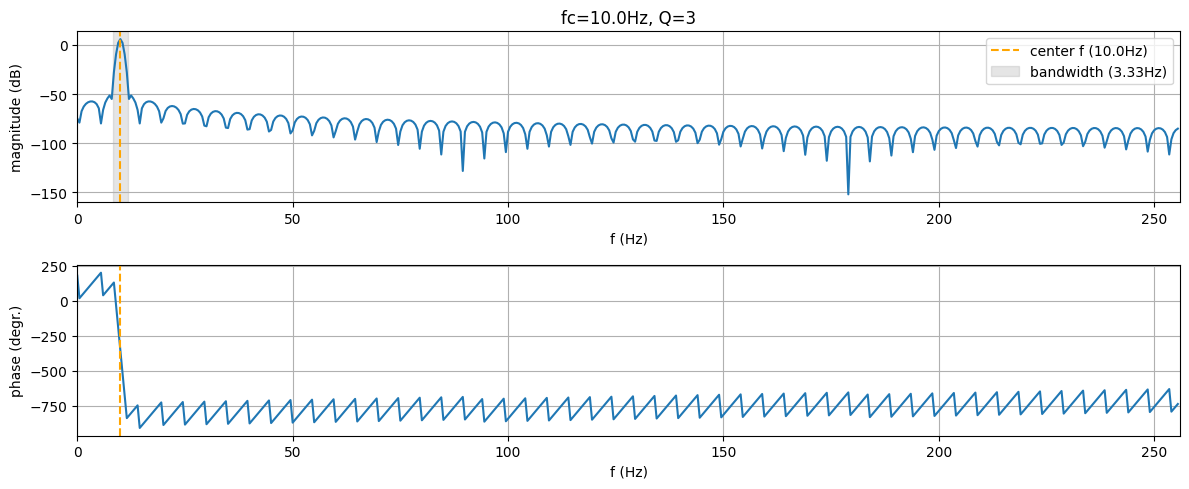

In [ ]:
# bw range...
df = fc_a / Q_a
cutoff_low = fc_a - df/2
cutoff_high = fc_a + df/2

plt.figure(figsize=(12, 5))

plt.subplot(2, 1, 1)
plt.plot(f, H)
plt.title(f'fc={fc_a}Hz, Q={Q_a}')
plt.xlabel('f (Hz)')
plt.ylabel('magnitude (dB)')
plt.grid(True)

plt.axvline(fc_a, color='orange', linestyle='--', label=f'center f ({fc_a}Hz)')
plt.axvspan(cutoff_low, cutoff_high, color='gray', alpha=0.2, label=f'bandwidth ({df:.2f}Hz)')
plt.legend()
plt.xlim(0, fs/2)


plt.subplot(2, 1, 2)
plt.plot(f, phase)
plt.xlabel('f (Hz)')
plt.ylabel('phase (degr.)')
plt.grid(True)

plt.axvline(fc_a, color='orange', linestyle='--', label=f'center f ({fc_a}Hz)')
plt.xlim(0, fs/2)

plt.tight_layout()
plt.show()

# 4. Instantaneous amplitude and freq

<>:13: SyntaxWarning: invalid escape sequence '\P'
<>:13: SyntaxWarning: invalid escape sequence '\P'
/tmp/ipython-input-1468419369.py:13: SyntaxWarning: invalid escape sequence '\P'
  plt.plot(t, phi, label='inst. phase ($\Phi(t)$)')


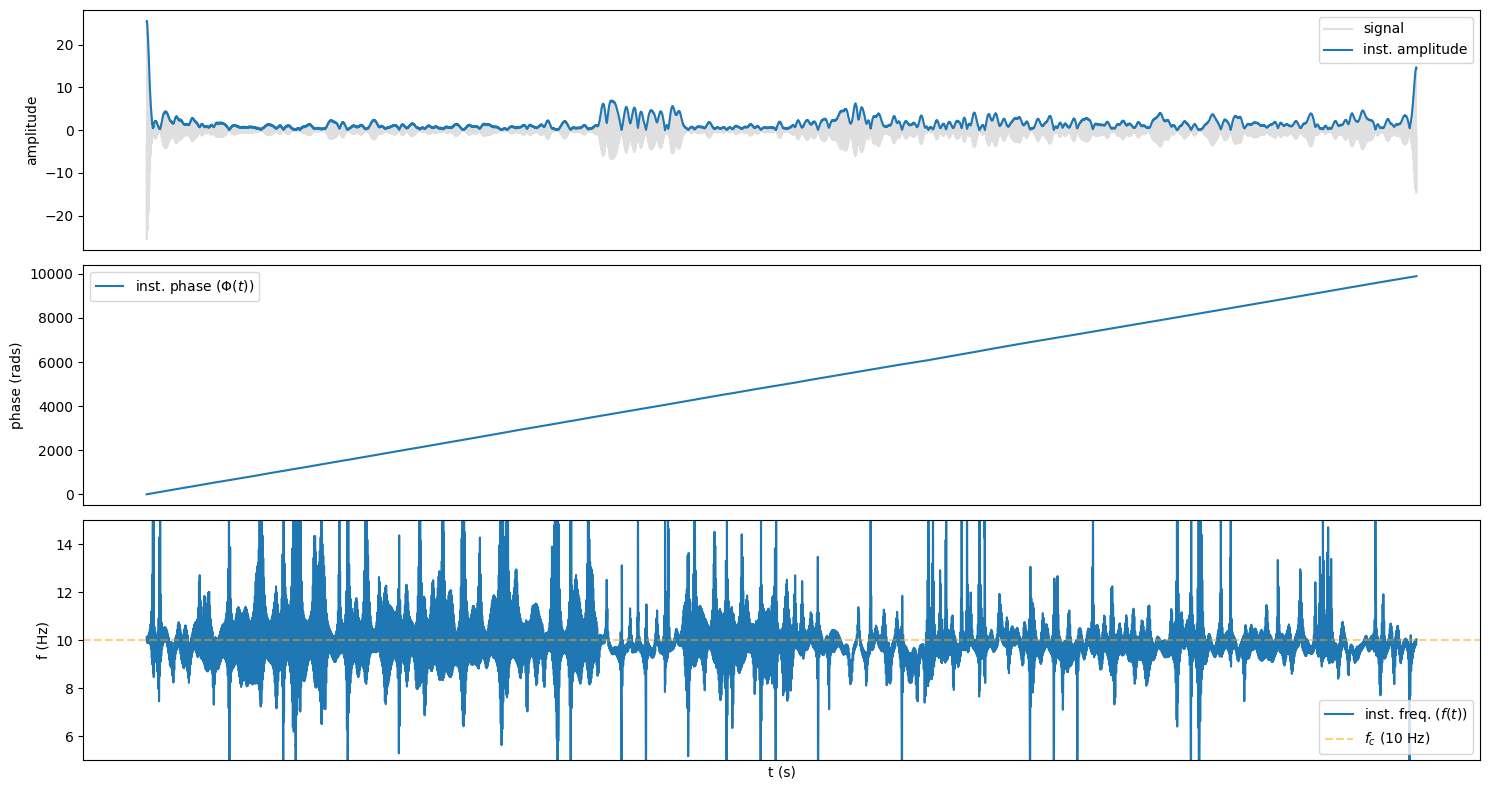

In [ ]:
plt.figure(figsize=(15, 8))

# signal
plt.subplot(3, 1, 1)
plt.plot(t, y_a, label='signal', color='gray', alpha=0.25)
plt.plot(t, y_a_env, label='inst. amplitude')
plt.ylabel('amplitude')
plt.xticks([])
plt.legend()

# inst phase
plt.subplot(3, 1, 2)
plt.plot(t, phi, label='inst. phase ($\Phi(t)$)')
plt.ylabel('phase (rads)')
plt.xticks([])
plt.legend()

# inst freq
plt.subplot(3, 1, 3)
plt.plot(t, ft, label='inst. freq. ($f(t)$)')
plt.axhline(fc_a, ls='--', c='orange', alpha=0.5, label='$f_c$ (10 Hz)')
plt.ylim(fc_a - 5, fc_a + 5)
plt.xlabel('t (s)')
plt.ylabel('f (Hz)')
plt.xticks([])
plt.legend()


plt.tight_layout()
plt.show()